# Predicting Shelter Animal Outcomes

**John Hoerr**, I526 SP18 Final Project

**Abstract**  
According to the ASPCA, approximately 6.5 million animals enter American animal shelters every year.  About 25% (1.5 million) of them are euthanized, down from about 40% (2.6 million) in 2011. We would like to increase this downward trend by helping shelter staff identify at-risk animals as quickly as possible. We propose to do this by modeling and classifying shelter animal outcomes using a combination of observable and historical features. This model can then be used to predict the outcome of shelter animals, which will help the staff to allocate resources in a way that maximizes their adoption goals.

# Phase 1

## Data Procurement
Our data source (and inspiration) for this project is the Kaggle competition, [Shelter Animal Outcomes](https://www.kaggle.com/c/shelter-animal-outcomes). The training data set includes outcomes for approximately 27,000 unique animals in the Austin, TX area from October 2013 to March 2016.

In [19]:
import numpy as np
import pandas as pd
import math as math

train = pd.read_csv('~/.kaggle/competitions/shelter-animal-outcomes/train.csv')
test = pd.read_csv('~/.kaggle/competitions/shelter-animal-outcomes/test.csv')

## Exploratory Data Analysis

The feature set includes:
1. **AnimalID** *(unique)*: A unique identifier  
2. **Name** *(string)*: The animal name, if available.
3. **DateTime** *(datetime)*: The timestamp of the outcome event.  
4. **AnimalType** *(enum: dog. cat)*: The animal genus (broadly.)
5. **SexuponOutcome** *(enum: intact male, intact female, neutered male, spayed female, unknown)*: The combined sex and reproductive status of the animal.
6. **AgeuponOutcome** *(timespan string)*: The animal's age at the time of the outcome.
7. **Breed** *(string)*: The animal's species (broadly.)
8. **Color** *(string)*: The animal's primary/secondary coloring and dominant pattern (if any).

The outputs (missing from *test.csv*) include:
1. **OutcomeType** *(enum: Adoption, Died, Euthanesia, Return_to_owner, Transfer)*: The primary outcome labels to be modeled and predicted.
2. **OutcomeSubtype** *(enum: Suffering, Foster, Partner, Offsite, SCRP, Aggressive, Behavior, Rabies Risk, Medical, In Kennel, In Foster, Barn, Court/Investigation, Enroute, At Vet, In Surgery)*: Secondary outcome labels (not predicted.)

In [20]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [21]:
test.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null object
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: object(10)
memory usage: 2.0+ MB


### Feature Observations

** Candidates for Engineering **
* **AgeuponOutcome** values are expressed in different units (days/months/years) and must be normalized to *days* or a general classification (baby/juvenile/adult/senior).
* **SexuponOutcome** combines sex and reproductive status (“fixed male”) combines to unique binary values (fixed/intact and male/female). These must be split into separate **Sex** and **ReproductiveStatus** features.
* **Breed** values are typically expressed as either a purebred (“Akita”), mix (“Akita mix”), or primary/secondary combination (“Akita/Husky”). These must either be split and/or consolidated;
* **Color** values are typically expressed as a primary/secondary combination (“Brown Tabby/White”) and must be split and/or consolidated.

** Candidates for Exclusion **
* The **AnimalID** feature is a unique identifier and has no predictive value.
* The **Name** feature is missing for ~30% of animals and is highly variable by nature. Including it would lead to OHE explosion. This may be useful for future sentiment analysis, but is not valuable for this classification.
* The **OutcomeSubtype** feature is missing for ~half of animals and typically depends on the unique circumstances of each animal; i.e. that an animal is suffering or rabid is not related to its age/sex/disposition generally.

** Candidates for Imputing **
* The **AgeuponOutome** is missing for a small handful of animals. A numeric value can be easily imputed following normalization; otherwise these entries can be removed.

### Feature Visualization

The goal of this project is to predict outcomes for the shelter animals. Let's break down the training outcomes based on various features to see if patterns emerge. We'll first filter out low-value columns and rows from our training data matrix.

In [23]:
# Drop low-value columns
eda = train.drop(['AnimalID', 'Name', 'OutcomeSubtype'], axis=1)
# Drop rows with N/A values in the specified columns
eda = eda.dropna(subset=['AgeuponOutcome', 'SexuponOutcome'])
eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26710 entries, 0 to 26728
Data columns (total 7 columns):
DateTime          26710 non-null object
OutcomeType       26710 non-null object
AnimalType        26710 non-null object
SexuponOutcome    26710 non-null object
AgeuponOutcome    26710 non-null object
Breed             26710 non-null object
Color             26710 non-null object
dtypes: object(7)
memory usage: 1.6+ MB


#### Outcome counts

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's plot counts of the outcomes in our training set to see how representative this sample is of the national trends. In this sample ~2000 animals (7.7%) died or were euthanized while in care. This is much less than the 25% average cull rate reported by the ASPCA. 

Text(0.5,1,'Outcomes')

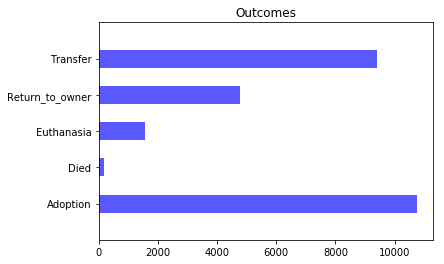

In [25]:
plt.figure(figsize=(6,4))
fig, ax = plt.subplots()
eda.OutcomeType.value_counts().sort_index().plot(kind='barh', color="blue", alpha=.65)
ax.set_ylim(-1, len(eda.OutcomeType.value_counts())) 
plt.title("Outcomes")

In [26]:
# Plot raw and proportional outcomes based on binary categories a, b.
def plotSideBySide(category, a, b):
    fig = plt.figure(figsize=(18,6))

    ax1 = fig.add_subplot(121)
    a[0].plot(kind='barh',label=a[1], alpha=0.55)
    b[0].plot(kind='barh', color='#FA2379',label=b[1], alpha=0.55, )
    ax1.set_ylim(-1, len(eda.OutcomeType.value_counts())) 
    plt.title(f"Outcomes with Respect to {category}, raw count"); plt.legend(loc='best')

    #adjust graph to display the proportions of survival by animal type
    ax2 = fig.add_subplot(122)
    (a[0]/float(a[0].sum())).plot(kind='barh',label=a[1], alpha=0.55)  
    (b[0]/float(b[0].sum())).plot(kind='barh', color='#FA2379',label=b[1], alpha=0.55)
    ax2.set_ylim(-1, len(eda.OutcomeType.value_counts())) 
    plt.title(f"Outcomes with Respect to {category}, proportional"); plt.legend(loc='best')

#### Outcome by Animal Type

Dogs are returned to owners at much higher rates, suggesting that many dogs are brought to shelters as strays (microchip your pets!). Cats are transfered to other shelters at higher rates. Dogs and cats are adopted and euthanized in roughly equal proportion. 

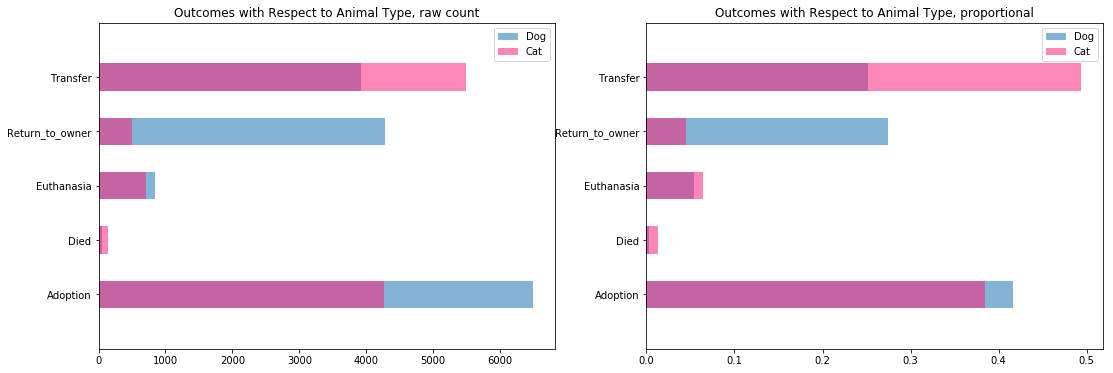

In [27]:
df_dog = eda.OutcomeType[eda.AnimalType == 'Dog'].value_counts().sort_index()
df_cat = eda.OutcomeType[eda.AnimalType == 'Cat'].value_counts().sort_index()
plotSideBySide('Animal Type', (df_dog, 'Dog'), (df_cat, 'Cat'))

#### Outcome by Age

Juvenile animals (less than 2 years old) are adopted at higher rates, whereas adult animals (2+ years old) are euthanized at higher rates. This is in line with intuition. Interestingly, most runaways tend to be adult animals.

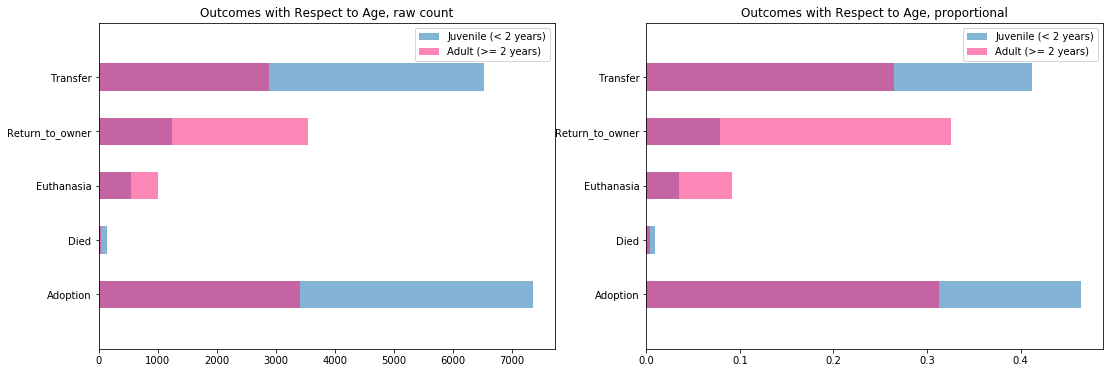

In [28]:
df_juvenile = eda.OutcomeType[eda.AgeuponOutcome.str.contains('years')==False].value_counts().sort_index()
df_adult = eda.OutcomeType[eda.AgeuponOutcome.str.contains('years')==True].value_counts().sort_index()
plotSideBySide("Age", (df_juvenile, "Juvenile (< 2 years)"), (df_adult, "Adult (>= 2 years)"))

#### Outcome by Sex and Reproductive Status

Female animals are adopted at slightly higher rates whereas male animals are euthanized at slightly higher rates.

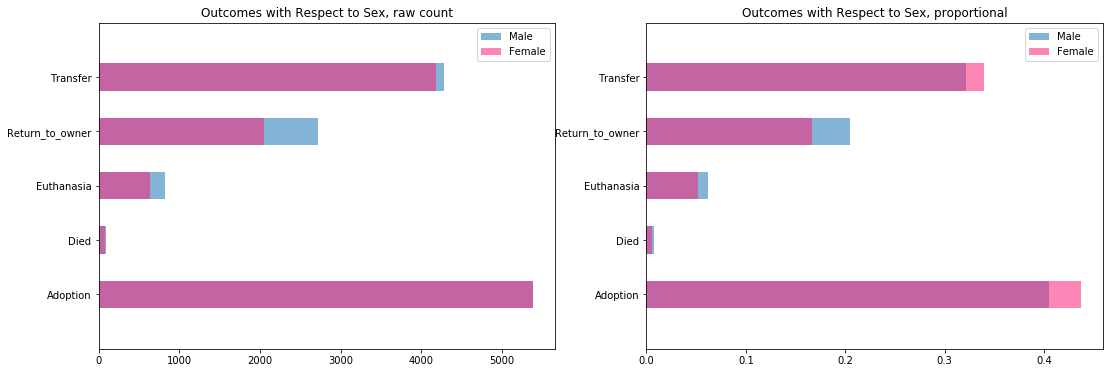

In [29]:
df_male = eda.OutcomeType[eda.SexuponOutcome.str.contains('Male')].value_counts().sort_index()
df_female = eda.OutcomeType[eda.SexuponOutcome.str.contains('Female')].value_counts().sort_index()
plotSideBySide("Sex", (df_male, 'Male'), (df_female, 'Female'))

Fixed animals are adopted a vastly higher rates whereas intact animals are euthanized at higher rates. This is in line with intuition.

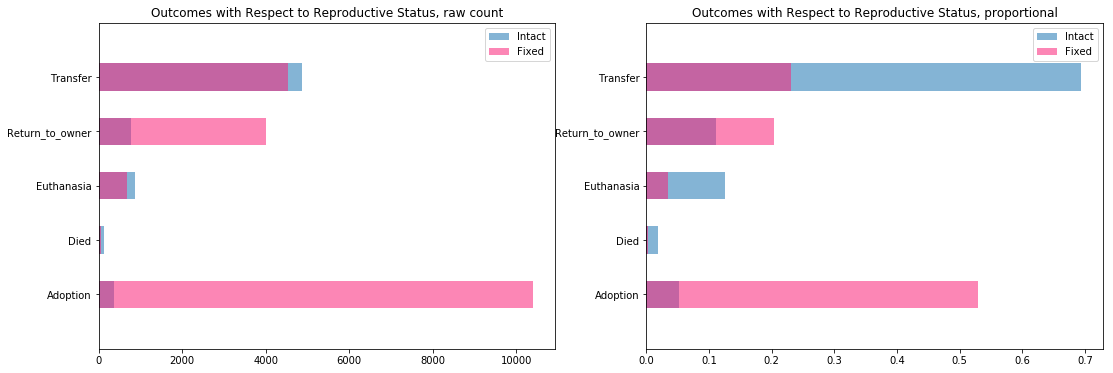

In [30]:
df_intact = eda.OutcomeType[eda.SexuponOutcome.str.contains('Intact') == True].value_counts().sort_index()
df_fixed = eda.OutcomeType[eda.SexuponOutcome.str.contains('Intact') == False].value_counts().sort_index()
plotSideBySide("Reproductive Status", (df_intact, "Intact"), (df_fixed, "Fixed"))

Female animals tend to fare marginally better than male animals with the same reproductive status.

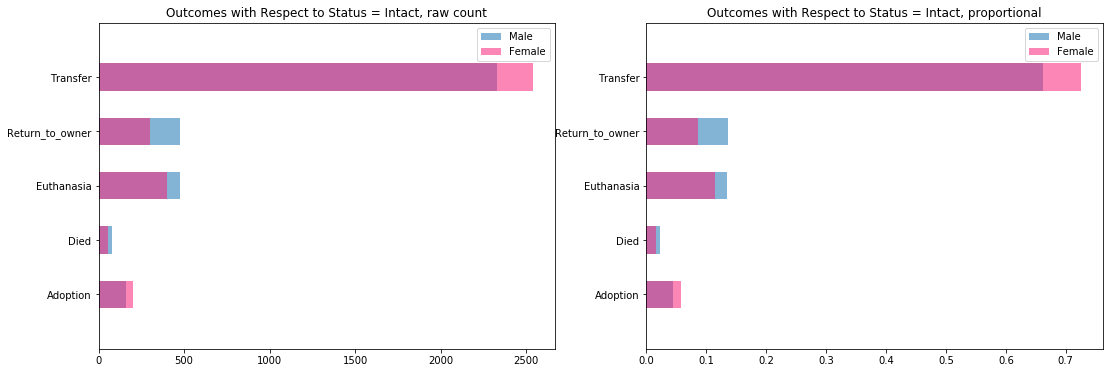

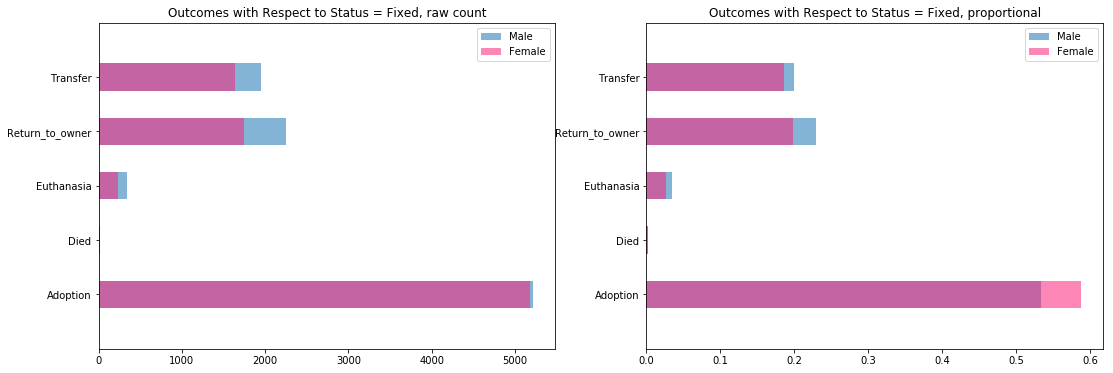

In [31]:
df_male_intact = eda.OutcomeType[eda.SexuponOutcome.str.contains('Male')][eda.SexuponOutcome.str.contains('Intact') == True].value_counts().sort_index()
df_female_intact = eda.OutcomeType[eda.SexuponOutcome.str.contains('Female')][eda.SexuponOutcome.str.contains('Intact') == True].value_counts().sort_index()
df_male_fixed = eda.OutcomeType[eda.SexuponOutcome.str.contains('Male')][eda.SexuponOutcome.str.contains('Intact') == False].value_counts().sort_index()
df_female_fixed = eda.OutcomeType[eda.SexuponOutcome.str.contains('Female')][eda.SexuponOutcome.str.contains('Intact') == False].value_counts().sort_index()
plotSideBySide("Status = Intact", (df_male_intact, "Male"), (df_female_intact, "Female"))
plotSideBySide("Status = Fixed", (df_male_fixed, "Male"), (df_female_fixed, "Female"))

## Metrics 
This is a multinomial classification problem. The classification algorithms we’ve studied are logistic regression and support vector machines, so these will be our primary candidates. As a stretch goal we will also consider decision trees/random forests, but this is contingent on on the timing of the course. Our goal is to correctly predict animal outcomes, so our primary metric will be classification accuracy. Let's set up a few things to help us capture performance data.

In [403]:
# Imports for metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, ShuffleSplit
# Imports for stats
from scipy import stats
from time import time, sleep
import pandas as pd
from IPython.display import display, HTML
                       
def pct(x): 
    """Convert a decimal to a percentage"""
    return round(100*x,1)

def ftime(f):
    """Time the execution of some lambda.
    Returns a tuple with the result of the lamdba, and the elapsed time.
    """
    t0 = time()
    x = f()
    elapsed = time() - t0
    return (x, round(elapsed, 2))

# Set up dataframe printing
def prettyPrintDf(df):
    display( HTML( df.to_html().replace("\\n","<br>") ) )
    
# Format results
def record(df, phase, group, name, train_score, val_score, p_val, train_time, val_time, best_params):
    df.loc[len(df)] = [ 
        phase, 
        group, 
        name, 
        round(train_score,6), 
        round(val_score,6), 
        round(p_val,6), 
        round(train_time, 2), 
        round(val_time, 2),
        best_params
    ]

In [404]:
scoring = 'neg_log_loss'

def ohe(preds):
    ohe = pd.get_dummies(preds)
    if ('Died' not in ohe):
        ohe['Died'] = [0]*len(ohe)
    return ohe

# A convenience functions to OHE and score the predicted vs true labels
def oheLogLoss(y_true, y_preds):
    return log_loss(ohe(y_true), y_preds)



## Baseline Models and Pipeline

In this section we will build a pipeline for a benchmark Logistic Regression model. For this benchmark we will simply one-hot encode the **AnimalType**, **SexuponOutcome**, **AgeuponOutcome**, **Breed**, and **Color** features. Data will be minimally manipulated; feature engineering will begin in earnest in Phase 2.

### Pipeline Preparation

The DataFrameSelector and CategoricalEncoder introduced in HW 10 are a great tools for slicing data frames and one-hot encoding features with text labels. We'll import that code and use it in our pipeline.

In [405]:
# Copy the CategoricalEncoder from HW10
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

The *CategoricalEncoder* does not deal well with categorical entries that lack labels (NaN), so we'll need a pipeline steap that can fill any empty/nan label cells with *Unknown* or similar. I'll call this a *CategoricalNormalizer*.

In [406]:
class CategoricalNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, value):
        self.value = value
    def normalize(self, X):
        # Coallesce an empty string to the fill value
        def mapStr(x): return (x.strip() or self.value) if x else self.value
        # Coallesce nan values to the fill value
        def mapCell(x): return mapStr(x) if isinstance(x, str) else self.value
        # Normalize every item in the row
        def mapRow(r): return list(map(mapCell, r))
        # Normalize every item in the 2D matrix
        return list(map(mapRow, X));
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        return self.normalize(X)

We'll now create a data pipeline to select and one-hot encode our columns of interest.

In [407]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

# Identify the categorical features we wish to consider.
cat_attribs = [
    "AnimalType",
    "SexuponOutcome",
    "AgeuponOutcome",
    "Color",
    "Breed"
]

# Create a pipelne for the categorical features.
# Entries with missing values or values that don't exist in the range
#   defined above will be one hot encoded as zeroes.
base_cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_normalizer', CategoricalNormalizer("Unknown")),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense", handle_unknown="ignore"))
    ])

### Data Preparation

Split the training data into train (80%) and validation (20%) sets.

In [408]:
from sklearn.model_selection import train_test_split

slimSize = 5000

train_split, val_split = train_test_split(train, test_size=0.2, random_state=42)

X_train = train_split
y_train = train_split.OutcomeType
print(f"Train (full): {X_train.shape}")

idx = np.random.choice(np.arange(len(X_train)), slimSize, replace=False)
X_train_slim = X_train[:slimSize]
y_train_slim = y_train[:slimSize]
print(f"Train (slim): {X_train_slim.shape}")

X_val = val_split
y_val = val_split.OutcomeType
print(f"Validation:   {X_val.shape}")

Train (full): (21383, 10)
Train (slim): (5000, 10)
Validation:   (5346, 10)


Let's see how many OHE columns we get as a result of our baseline transform.

In [409]:
X_train_tx = base_cat_pipeline.fit_transform(X_train)
X_train_slim_tx = base_cat_pipeline.transform(X_train_slim)
X_val_tx = base_cat_pipeline.transform(X_val)

print (f"Train (full): {X_train_tx.shape}")
print (f"Train (slim): {X_train_slim_tx.shape}")
print (f"Validation:   {X_val_tx.shape}")

Train (full): (21383, 1629)
Train (slim): (5000, 1629)
Validation:   (5346, 1629)


We went from 10 columns in the raw dataframe to 1629 columns in the transformed dataframe. That sure seems like a lot!

### Model Fitting and Scoring

For a baseline model we'll use a LogisticRegressionCV with the following non-default paramters:
+ *solver='**liblinear**'* for speed, 
+ *multi_class='**ovr**'* for a confidence floor (a single label is selected), 
+ *scoring='**neg_log_loss**'* to align with Kaggle scoring metric.

In [410]:
from sklearn.linear_model import LogisticRegressionCV


# Create baseline model
baseline = LogisticRegressionCV(solver="liblinear", multi_class="ovr", scoring=scoring, random_state=42)

# Fit
(_, train_elapsed) = ftime(lambda: baseline.fit(X_train_slim_tx, y_train_slim))

# Predict
train_preds = baseline.predict_proba(X_train_slim_tx)
(val_preds, val_elapsed) = ftime(lambda: baseline.predict_proba(X_val_tx))

# Score
train_score = oheLogLoss(y_train_slim, train_preds)
val_score = oheLogLoss(y_val, val_preds)

In [411]:
# Scores for P-value
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
baseline_scores = -1 * cross_val_score(baseline, X_train_slim_tx, y_train_slim, cv=cv, scoring=scoring)
baseline_scores

array([ 0.90114389,  0.91225871,  0.89197924,  0.92656582,  0.92987268,
        0.89316259,  0.92486578,  0.92180166,  0.92898783,  0.90223599,
        0.91205544,  0.90746062,  0.92440001,  0.91561221,  0.91811968,
        0.92214791,  0.93217297,  0.92524216,  0.93721522,  0.89906193,
        0.91409221,  0.90876064,  0.93703825,  0.90167652,  0.90960944,
        0.91540324,  0.92047886,  0.90181657,  0.96056694,  0.93016893])

In [412]:
# Set up reporting data frame.
results = pd.DataFrame(columns=["Phase", "Pipeline", "Classifier", "Train Log Loss", "Validation Log Loss", "p-value", "Train Time (s)", "Test Time (s)", "Experiment description"])
# Record and print baseline results
record(results, 1, "Baseline", "LogisticRegression (Ctl)", train_score, val_score, 0, train_elapsed, val_elapsed, "multi_class: ovr\nsolver: liblinear")
prettyPrintDf(results)

,Phase,Pipeline,Classifier,Train Log Loss,Validation Log Loss,p-value,Train Time (s),Test Time (s),Experiment description
0,1,Baseline,LogisticRegression (Ctl),0.838004,0.907733,0,3.31,0.05,multi_class: ovrsolver: liblinear


## Report

### Kaggle Submission

In [413]:
def kaggleSubmission(pipeline, estimator):
    X_test = pipeline.transform(test)
    test_preds = estimator.predict_proba(X_test)
    df = pd.DataFrame()
    df.insert(0, "ID", test.ID)
    df.insert(1, "Adoption", test_preds[:,0])
    df.insert(2, "Died", test_preds[:,1])
    df.insert(3, "Euthanasia", test_preds[:,2])
    df.insert(4, "Return_to_owner", test_preds[:,3])
    df.insert(5, "Transfer", test_preds[:,4])
    path = f'/users/jhoerr/Documents/baseline_submission_{time()}.csv'
    df.to_csv(path, index=False)
    print (f"Saved file to {path}")
    
kaggleSubmission(base_cat_pipeline, baseline)

Saved file to /users/jhoerr/Documents/baseline_submission_1524013840.817586.csv


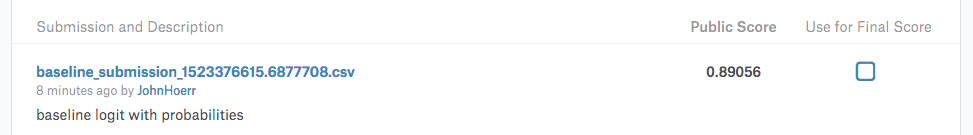

### Remarks

Our baseline model's validation prediction log-loss was 0.88. The Kaggle submission log-loss (above) was 0.89. This put it in the bottom half of Kaggle submissions (rank ~930 of ~1600.) There's obviously a lot of room for improvement.

Feature engineering in Phase 2 will help us reign in the OHE feature explosion that occured with the training data in Phase 1. We'll start with the candidates identified in [Section 2.2.1 Feature Observations](#Feature-Observations).

# Phase 2

## Revisions to Phase 1

I discovered that LinearRegressionCV provides several prediction methods. *Predict()* assigns a single label per sample, whereas *Predict_proba()* assigns the probability of each label. The later method aligns with Kaggles scoring metric. I retooled the baseline classifier to use this probabilistic prediction method and realized a reduction of the baseline log-loss from ~12 to ~0.89 and improved our Kaggle rank from ~1400 to ~930. I will limit classifier selection to those that implement probabilistic predictions.

## Feature Engineering (Round 1)

In [Section 2.2.1 Feature Observations](#Feature-Observations) we identified several candidates for feature engineering.

* **AgeuponOutcome** values are expressed in different units (days/months/years) and must be normalized to *days* or a general classification (baby/juvenile/adult/senior).
* **SexuponOutcome** combines sex and reproductive status (“fixed male”) combines to unique binary values (fixed/intact and male/female). These must be split into separate **Sex** and **ReproductiveStatus** features.
* **Breed** values are typically expressed as either a purebred (“Akita”), mix (“Akita mix”), or primary/secondary combination (“Akita/Husky”). These must either be split and/or consolidated;
* **Color** values are typically expressed as a primary/secondary combination (“Brown Tabby/White”) and must be split and/or consolidated.

In [414]:
import numpy as np
import pandas as pd
import math as math

# Helper functions

# Return the ith string in a list or "none"
def nth(a, i): 
    return a[i].lower().strip() if len(a) > i else "none" 
# Return the first string in the list or "none"
def fst(a): return nth(a, 0)
# Return the second string in the list or "none"
def snd(a): return nth(a, 1)
# determine if this value is empty/nan
def nothing(s): 
    return isinstance(s, float) or not s or not s.strip()
# Return a new dataframe with the 
def append(df, label, data):
    cp = pd.DataFrame.copy(df)
    cp.insert(len(df.columns), label, data)
    return cp

### Normalize *AgeuponOutcome*

New Column: **AgeInDays**  
Purpose: Convert values like '1 week' and '5 months' to an equivalent number of days. Missing values will be converted to NaN and imputed prior to scaling.

#### Transformer

In [415]:
from sklearn.base import BaseEstimator, TransformerMixin

class AgeNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def parseNumUnit(s):
            if nothing(s): return (0, 'nan')
            parts = s.strip().lower().split(' ')
            return (int(parts[0]), parts[1])
        def ageInDays(s):
            (num, unit) = parseNumUnit(s)
            if   'day'   in unit: return num
            elif 'week'  in unit: return num * 7
            elif 'month' in unit: return num * 30
            elif 'year'  in unit: return num * 365
            else: return math.nan

        X = append(X, 'AgeInDays', list(map(ageInDays, X['AgeuponOutcome'])))
        return X

#### Unit Test

In [416]:
sut = AgeNormalizer()

In [417]:
# Test Conversion
values =   [ '1 day', '2 days', '1 week', '2 weeks', '1 month', '3 months', '1 year', '3 years']
expected = [      1,        2,      1*7,       2*7,     1*30,        3*30,    1*365,     3*365]

df = pd.DataFrame()
df['AgeuponOutcome'] = values
actual = sut.transform(df)

print((actual.AgeInDays == expected).all())

True


In [418]:
# Test Empty String Handling
values =   [ ' ', '']

df = pd.DataFrame()
df['AgeuponOutcome'] = values
actual = sut.transform(df)

print(all(math.isnan(val) for val in actual.AgeInDays))

True


### Split *SexuponOutcome*

New Columns: **Sex**, **Status**  
Purpose: Split combined sex and reproductive status ("fixed male") values into separate columns. Missing values will be labeld as 'unknown'.

#### Transformer

In [419]:
from sklearn.base import BaseEstimator, TransformerMixin

class SexNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def sex(s):
            if nothing(s): return "unknown"
            return "female" if "female" in s.lower() else "male"
        def status(s):
            if nothing(s): return "unknown"
            return "intact" if "intact" in s.lower() else "fixed"
        
        X = append(X, 'Sex', list(map(sex, X['SexuponOutcome'])))
        X = append(X, 'Status', list(map(status, X['SexuponOutcome'])))
        return X

#### Unit Test

In [420]:
df = pd.DataFrame()
df['SexuponOutcome'] = [ 'Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female']

actual = SexNormalizer().transform(df)

In [421]:
expected = [ 'male', 'female', 'male', 'female']
print((actual.Sex == expected).all())

True


In [422]:
expected = [ 'fixed', 'fixed', 'intact', 'intact']
print((actual.Status == expected).all())

True


### Normalize *Color*

New Columns: **PrimaryColor**, **PrimaryPattern**, **SecondaryColor**, **SecondaryPattern**  
Purpose: Split combined primary/secondary color/pattern ("Brown Tabby/White") into separate columns. Similar colors ("orange", "apricot", "flame") will be combined ("orange.") Missing values will be labeled as 'none'. 

#### Explore

In [423]:
vals = train.Color.values

primary_color = list(map(lambda s: fst(fst(s.split("/")).split(" ")), vals))
print(f"\nPrimary Colors:\n{np.unique((primary_color))}")

primary_pattern = list(map(lambda s: snd(fst(s.split("/")).split(" ")), vals))
print(f"\nPrimary Patterns:\n{np.unique(np.sort(primary_pattern))}")

secondary_color = list(map(lambda s: fst(snd(s.split("/")).split(" ")), vals))
print(f"\nSecondary Colors:\n{np.unique(np.sort(secondary_color))}")

secondary_pattern = list(map(lambda s: snd(snd(s.split("/")).split(" ")), vals))
print(f"\nSecondary Patterns:\n{np.unique(np.sort(secondary_pattern))}")


Primary Colors:
['agouti' 'apricot' 'black' 'blue' 'brown' 'buff' 'calico' 'chocolate'
 'cream' 'fawn' 'flame' 'gold' 'gray' 'lilac' 'liver' 'lynx' 'orange'
 'pink' 'red' 'ruddy' 'sable' 'seal' 'silver' 'tan' 'torbie' 'tortie'
 'tricolor' 'white' 'yellow']

Primary Patterns:
['brindle' 'cream' 'lynx' 'merle' 'none' 'point' 'smoke' 'tabby' 'tick'
 'tiger']

Secondary Colors:
['apricot' 'black' 'blue' 'brown' 'buff' 'calico' 'chocolate' 'cream'
 'flame' 'gold' 'gray' 'liver' 'lynx' 'none' 'orange' 'pink' 'red' 'seal'
 'silver' 'tan' 'tortie' 'tricolor' 'white' 'yellow']

Secondary Patterns:
['brindle' 'cream' 'merle' 'none' 'point' 'smoke' 'tabby' 'tick' 'tiger']


#### Transformer

In [424]:
from sklearn.base import BaseEstimator, TransformerMixin

class ColorNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def color(s): 
            if s in "black": return "black"
            elif s in "white": return "white"
            elif s in ["blue", "silver", "lilac"]: return "blue"
            elif s in ["orange","apricot", "flame"]: return "orange"
            elif s in ["red", "ruddy", "pink", "liver"]: return "red"
            elif s in ["brown", "chocolate", "sable", "seal"]: return "brown"
            elif s in ["yellow", "gold", "buff", "cream", "fawn", "tan"]: return "yellow"
            elif s in ["agouti", "calico", "torbie", "tortie", "tricolor", "lynx"]: return "multi"
            else: return s
        
        def primaryColor(s): return "col_" + color(fst(fst(s.split("/")).split(" ")))
        def primaryPattern(s): return "pat_" + snd(fst(s.split("/")).split(" "))
        def secondaryColor(s): return "col_" + color(fst(snd(s.split("/")).split(" ")))
        def secondaryPattern(s): return "pat_" + snd(snd(s.split("/")).split(" "))
            
        X = append(X, 'PrimaryColor', list(map(primaryColor, X['Color'])))
        X = append(X, 'PrimaryPattern', list(map(primaryPattern, X['Color'])))
        X = append(X, 'SecondaryColor', list(map(secondaryColor, X['Color'])))
        X = append(X, 'SecondaryPattern', list(map(secondaryPattern, X['Color'])))
        return X

#### Unit Test

In [425]:
df = pd.DataFrame()
df['Color'] = [ 'Brown', 'Brown/White', 'orange tabby/white', 'flame brindle/lilac tiger']

actual = ColorNormalizer().transform(df)

In [426]:
expected = [ 'col_brown', 'col_brown', 'col_orange', 'col_orange']
print((actual.PrimaryColor == expected).all())

True


In [427]:
expected = [ 'pat_none', 'pat_none', 'pat_tabby', 'pat_brindle']
print((actual.PrimaryPattern == expected).all())

True


In [428]:
expected = [ 'col_none', 'col_white', 'col_white', 'col_blue']
print((actual.SecondaryColor == expected).all())

True


In [429]:
expected = [ 'pat_none', 'pat_none', 'pat_none', 'pat_tiger']
print((actual.SecondaryPattern == expected).all())

True


### Normalize *Breed*

New Columns: **PrimaryBreed**, **Secondary Breed**, **PureOrMix**  
Purpose: Split combined primary/secondary breed ("Yorkshire Terrier/Pomeranian"). Flag pure and mixed breeds. Optionally reduce the number of breed labels by marking the animal as 'exotic' if its breed representation frequency within the sample is lower than some *exotic_frequency_threshold* (def=0).


#### Explore

In [430]:
vals = train.Breed.values

print(np.unique(vals))

['Abyssinian Mix' 'Affenpinscher Mix' 'Afghan Hound Mix' ...,
 'Yorkshire Terrier/Pomeranian' 'Yorkshire Terrier/Rat Terrier'
 'Yorkshire Terrier/Toy Poodle']


#### Transformer

In [431]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter

class BreedNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, exotic_frequency_threshold=0):
        self.exotic_frequency_threshold = exotic_frequency_threshold
        
    def trimMix(self, s): return s.replace("mix", "").strip().replace(' ', '_')
    def primaryBreed(self, s): return self.trimMix(fst(s.split("/")))
    def secondaryBreed(self, s): return self.trimMix(snd(s.split("/")))
    
    def fit(self, X, y=None):
        X = append(X, 'PrimaryBreedFreq', list(map(self.primaryBreed, X['Breed'])))
        self.breed_freq = X.PrimaryBreedFreq.value_counts(normalize=True)
        return self
    
    def transform(self, X):
        def resolvedBreed(b):
            if b in "none": return 'bre_none'
            elif b not in self.breed_freq or self.breed_freq[b] < self.exotic_frequency_threshold: return 'bre_exotic'
            else: return "bre_"+b
        def resolvePrimaryBreed(s): return resolvedBreed(self.primaryBreed(s))
        def resolveSecondaryBreed(s): return resolvedBreed(self.secondaryBreed(s))
        def pureOrMix(s): return "mix" if ("Mix" in s or "/" in s) else "pure"
            
        X = append(X, 'PrimaryBreed', list(map(resolvePrimaryBreed, X['Breed'])))
        X = append(X, 'SecondaryBreed', list(map(resolveSecondaryBreed, X['Breed'])))
        X = append(X, 'PureOrMix', list(map(pureOrMix, X['Breed'])))
        return X

#### Unit Test

In [432]:
df = pd.DataFrame()
df['Breed'] = [ 'Foo', 'Foo Mix/Bar', 'Bar Mix', 'Baz/Foo']

sut = BreedNormalizer(0)
sut.fit(df)
actual = sut.transform(df)

In [433]:
expected = [ .50, .25, .25 ]
print((sut.breed_freq == expected).all())

True


In [434]:
expected = [ 'bre_foo', 'bre_foo', 'bre_bar', 'bre_baz' ]
print((actual.PrimaryBreed == expected).all())

True


In [435]:
expected = [ 'bre_none', 'bre_bar', 'bre_none', 'bre_foo' ]
print((actual.SecondaryBreed == expected).all())

True


In [436]:
expected = [ 'pure', 'mix', 'mix', 'mix' ]
print((actual.PureOrMix == expected).all())

True


## Engineered Pipeline

This engineered pipeline uses many of the new engineered features in an effort to reduce the number of OHE features without losing too much information.

In [437]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_attribs = ["AgeInDays"]
num_pipeline = Pipeline([
        ('normalize_age', AgeNormalizer()), # derive AgeInDays 
        #('print', Printer()),
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

cat_attribs = [
    "AnimalType", 
    "Sex", 
    "Status", 
    "PrimaryColor", 
    "PrimaryPattern", 
    "SecondaryColor", 
    "PrimaryBreed",
    "SecondaryBreed",
    "PureOrMix"
]

cat_pipeline = Pipeline([
        ('normalize_sex', SexNormalizer()),
        ('normalize_color', ColorNormalizer()),
        ('normalize_breed', BreedNormalizer(0.00001)),
        #('print', Printer()),
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense", handle_unknown="ignore"))
    ])

from sklearn.pipeline import FeatureUnion

eng_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

## Grid Search

Create a grid search harness that will be reused throughout the rest of the project. Test against a range of classifiers, including a control classifier ("LogisticRegression (Ctl)") that uses the same configuration as our baseline. This control classifier is intended to provide some insight into the general value of the choice of features. All classifiers must support probabilistic prediction (clf.*predict_proba()*) in order to maintain consistent scoring.

In [438]:
import json
from time import time
from math import sqrt
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from scipy import stats 

In [439]:
def printParams(ptype, pkeys, pdict):
    param_dump = ""
    if pkeys: 
        print(f"** {ptype} Parameters **")
        for p in sorted(pkeys):
            param_dump += f"{p}: {pdict[p]}\n"
        print(param_dump)
    return param_dump

def calculatePValue(clf, X, y):
    print("Calculating P-value...")
    # Generate 30 training accuracy scores with the best estimator and 30-split CV
    cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
    (grid_scores, elapsed) = ftime(lambda: -1 * cross_val_score(clf, X, y, cv=cv, scoring=scoring))
    print(f"Calculated P-value in {elapsed} s\n")
    # Conduct t-test with baseline logit (control) and best estimator (experiment)
    (t_stat, p_value) = stats.ttest_rel(baseline_scores, grid_scores)
    return p_value

# A Function to execute the grid search and record the results.
def ConductGridSearch(phase, group, pipeline, classifiers, params_grid):
    
    X_train_gs = pipeline.fit_transform(X_train)
    X_train_slim_gs = pipeline.transform(X_train_slim)
    X_val_gs = pipeline.transform(X_val)
    
    print (f"Train (full): {X_train_gs.shape}")
    print (f"Train (slim): {X_train_slim_gs.shape}")
    print (f"Validation:   {X_val_gs.shape}\n")

    for (name, classifier) in classifiers:
        # Print classifier and parameters
        print(f"****** START Phase {phase} - {group} - {name}  *****\n")
        
        # Get parameter grid for this classifier
        parameters = params_grid[name]
        printParams("Search", parameters.keys(), parameters)
        
        # Execute the grid search on slim training data set
        grid_search = GridSearchCV(classifier, parameters, scoring=scoring, cv=3, verbose=1)
        grid_search.fit(X_train_slim_gs, y_train_slim)
        clf = grid_search.best_estimator_
        
        # Collect the best parameters found by the grid search
        best_params = printParams("Best", parameters.keys(), clf.get_params())
        
        # Time Fit on full data set
        print("Validating best estimator...")
        (_, train_time) = ftime(lambda: clf.fit(X_train_slim_gs, y_train_slim))
        
        # Time Predict
        train_preds = clf.predict_proba(X_train_slim_gs)
        (val_preds, val_time) = ftime(lambda: clf.predict_proba(X_val_gs))
        
        # Score
        train_score = round(oheLogLoss(y_train_slim, train_preds),6)
        val_score = round(oheLogLoss(y_val, val_preds),6)
        p_value = round(calculatePValue(clf, X_train_slim_gs, y_train_slim),6)
        
        # Record the results
        record(results, phase, group, name, train_score, val_score, p_value, train_time, val_time, best_params)
        print("** Results **")
        print(f"Best train log-loss: {train_score}")
        print(f"Best validation log-loss: {val_score}")
        print(f"P-value: {p_value}")
        
        print(f"\n****** Finish Phase {phase} - {group} - {name}  *****\n\n")


In [440]:
# Create a list of classifiers for our grid search experiment
classifiers = [
    ('LogisticRegression (Ctl)', LogisticRegressionCV(solver="liblinear", multi_class="ovr", scoring=scoring, random_state=42)),
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('Stochastic GD', SGDClassifier(random_state=42, n_jobs=-1))
]

# Arrange grid search parameters for each classifier
params_grid = {
    'LogisticRegression (Ctl)': {},
    'LogisticRegression': {
        'solver': ('lbfgs', 'newton-cg', 'sag'),
        'multi_class': ('ovr', 'multinomial'),
        'tol': (1, 0.1, 0.01, 0.001, 0.0001), 
    },
    'Stochastic GD': {
        'loss': ('log', 'modified_huber'),
        'penalty': ('l1', 'l2', 'elasticnet'),
        'tol': (1, 0.1, 0.01, 0.001, 0.0001), 
        'alpha': (1, 0.1, 0.01, 0.001, 0.0001), 
    }
}

### Baseline Features

In [441]:
if __name__ == "__main__":
    ConductGridSearch(2, "Baseline", base_cat_pipeline, classifiers, params_grid)

Train (full): (21383, 1629)
Train (slim): (5000, 1629)
Validation:   (5346, 1629)

****** START Phase 2 - Baseline - LogisticRegression (Ctl)  *****

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.6s finished


Validating best estimator...
Calculating P-value...
Calculated P-value in 64.93 s

** Results **
Best train log-loss: 0.838004
Best validation log-loss: 0.907733
P-value: nan

****** Finish Phase 2 - Baseline - LogisticRegression (Ctl)  *****


****** START Phase 2 - Baseline - LogisticRegression  *****

** Search Parameters **
multi_class: ('ovr', 'multinomial')
solver: ('lbfgs', 'newton-cg', 'sag')
tol: (1, 0.1, 0.01, 0.001, 0.0001)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  4.1min finished


** Best Parameters **
multi_class: ovr
solver: sag
tol: 0.01

Validating best estimator...
Calculating P-value...
Calculated P-value in 106.69 s

** Results **
Best train log-loss: 0.795478
Best validation log-loss: 0.913073
P-value: 0.0

****** Finish Phase 2 - Baseline - LogisticRegression  *****


****** START Phase 2 - Baseline - Stochastic GD  *****

** Search Parameters **
alpha: (1, 0.1, 0.01, 0.001, 0.0001)
loss: ('log', 'modified_huber')
penalty: ('l1', 'l2', 'elasticnet')
tol: (1, 0.1, 0.01, 0.001, 0.0001)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  2.2min finished


** Best Parameters **
alpha: 0.001
loss: log
penalty: elasticnet
tol: 0.0001

Validating best estimator...
Calculating P-value...
Calculated P-value in 12.05 s

** Results **
Best train log-loss: 0.87967
Best validation log-loss: 0.911208
P-value: 0.000199

****** Finish Phase 2 - Baseline - Stochastic GD  *****




In [442]:
prettyPrintDf(results)

,Phase,Pipeline,Classifier,Train Log Loss,Validation Log Loss,p-value,Train Time (s),Test Time (s),Experiment description
0,1,Baseline,LogisticRegression (Ctl),0.838004,0.907733,0,3.31,0.05,multi_class: ovrsolver: liblinear
1,2,Baseline,LogisticRegression (Ctl),0.838004,0.907733,NaN,2.95,0.03,
2,2,Baseline,LogisticRegression,0.795478,0.913073,0,5.19,0.03,multi_class: ovrsolver: sagtol: 0.01
3,2,Baseline,Stochastic GD,0.879670,0.911208,0.000199,0.53,0.02,alpha: 0.001loss: logpenalty: elasticnet...


### Engineered Features

In [443]:
if __name__ == "__main__":
    ConductGridSearch(2, "Engineered", eng_pipeline, classifiers, params_grid)

Train (full): (21383, 390)
Train (slim): (5000, 390)
Validation:   (5346, 390)

****** START Phase 2 - Engineered - LogisticRegression (Ctl)  *****

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s finished


Validating best estimator...
Calculating P-value...
Calculated P-value in 50.51 s

** Results **
Best train log-loss: 0.955817
Best validation log-loss: 0.978037
P-value: 0.0

****** Finish Phase 2 - Engineered - LogisticRegression (Ctl)  *****


****** START Phase 2 - Engineered - LogisticRegression  *****

** Search Parameters **
multi_class: ('ovr', 'multinomial')
solver: ('lbfgs', 'newton-cg', 'sag')
tol: (1, 0.1, 0.01, 0.001, 0.0001)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_

** Best Parameters **
multi_class: ovr
solver: sag
tol: 0.1

Validating best estimator...
Calculating P-value...
Calculated P-value in 10.61 s

** Results **
Best train log-loss: 0.935025
Best validation log-loss: 0.987704
P-value: 0.0

****** Finish Phase 2 - Engineered - LogisticRegression  *****


****** START Phase 2 - Engineered - Stochastic GD  *****

** Search Parameters **
alpha: (1, 0.1, 0.01, 0.001, 0.0001)
loss: ('log', 'modified_huber')
penalty: ('l1', 'l2', 'elasticnet')
tol: (1, 0.1, 0.01, 0.001, 0.0001)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  1.1min finished


** Best Parameters **
alpha: 0.001
loss: log
penalty: l1
tol: 0.001

Validating best estimator...
Calculating P-value...
Calculated P-value in 3.53 s

** Results **
Best train log-loss: 0.983428
Best validation log-loss: 0.979151
P-value: 0.0

****** Finish Phase 2 - Engineered - Stochastic GD  *****




In [444]:
prettyPrintDf(results)

,Phase,Pipeline,Classifier,Train Log Loss,Validation Log Loss,p-value,Train Time (s),Test Time (s),Experiment description
0,1,Baseline,LogisticRegression (Ctl),0.838004,0.907733,0,3.31,0.05,multi_class: ovrsolver: liblinear
1,2,Baseline,LogisticRegression (Ctl),0.838004,0.907733,NaN,2.95,0.03,
2,2,Baseline,LogisticRegression,0.795478,0.913073,0,5.19,0.03,multi_class: ovrsolver: sagtol: 0.01
3,2,Baseline,Stochastic GD,0.879670,0.911208,0.000199,0.53,0.02,alpha: 0.001loss: logpenalty: elasticnet...
4,2,Engineered,LogisticRegression (Ctl),0.955817,0.978037,0,2.58,0.01,
5,2,Engineered,LogisticRegression,0.935025,0.987704,0,0.51,0.01,multi_class: ovrsolver: sagtol: 0.1
6,2,Engineered,Stochastic GD,0.983428,0.979151,0,0.11,0.01,alpha: 0.001loss: logpenalty: l1tol: 0.0...


## Report

Phase 2 produce no meaningful improvements in prediction accuracy. Two rounds of grid search testing were conducted: first against the raw data/features, and then against the first round of engineered features. The raw features garnered a lower log-loss than the engineered features for all classifiers, indicating that our first round feature engineering was ineffective. One bright spot is that feature engineering has reduced the delta between training and validation log-loss, indicating that feature engineering has reduced the models' tendency towards overfitting.

Phase 3 will focus on more feature engineering. I'm going to explore binning dog breeds into the classic groups (i.e. herding, sporting, hound) to see if that provides any measurable improvement. It is becoming clear to me that in many cases the data simply doesn't support he situational circumstances that lead to an animals eventual outcome: one can't infer that a cat is sick and dying because it is a male with brown fur. No amount of feature engineering can improve predictions if the underlying data simply isn't there.

# Phase 3

## Revisions to Phase 2

* On reviewing [Feature Importance](#Feature-Importance) I discovered a few issues in my engineering pipeline:  
  +  The *SexNormalizer* was failing to process the *Female* and *Spayed/Neutered* cases as expected: all animals were being encoded as *Fixed Males*. I resolved the error to an string comparison bug.
  +  The *ColorNormalizer* and *BreedNormalizer* were both using *None* for cases where a value wasn't present. I thought this might cause some confusion for the one-hot encoder, so I prefixed each color, pattern, and breed label with *col_*, *pat_*, and *bre_* respectively.   
  

* I was planning to do another round of feature engineering but instead opted to explore some ensemble classifiers, including the 'Bagged' SVC, RandomForest, and XGBoost. I kept the Logit and Stochastic GD classifiers in Phase 2.

* In the interest of time I switched to a grid search with a 5000-count random sample of the whole. This didn't seem to cause a noticeable difference in the end result.

## Ensemble Grid Search

Grid search several powerful ensemble classifiers against the baseline and engineered features.

In [460]:
from sklearn.ensemble import BaggingClassifier

# Create a list of classifiers for our grid search experiment
classifiers = [
    ('Bagging SVM', BaggingClassifier(SVC(probability=True, decision_function_shape="ovo", random_state=42), n_estimators=8, random_state=42, n_jobs=-1)),
    ('Random Forest', RandomForestClassifier(random_state=42, n_jobs=-1)),        
    ('XGBoost', XGBClassifier(objective="multi:softprob", eval_metric="logloss", random_state=42, n_jobs=-1))
]

# Arrange grid search parameters for each classifier
params_grid = {
    'Bagging SVM': {
        'base_estimator__kernel': ['rbf', 'poly', 'sigmoid'],
        'base_estimator__tol': (1, 0.1, 0.01, 0.001, 0.0001),
        'base_estimator__C': [1, 10, 100],
    },
    'Random Forest':  {
        'criterion': ['gini', 'entropy'],
        'max_depth': [10, 20],
        'max_features': ("sqrt", None),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5],
        'n_estimators': (50, 75),        
    },
    'XGBoost': {
        'max_depth': [3, 6, 10],
        'learning_rate': [0.3, 0.5],
        'reg_lambda': (1, 10, 100), 
        'reg_alpha': (1, 0.1, 0.01), 
        'subsample': [0.5, 1],
        'gamma': [1, 10]
    }   
}

### Baseline Features

In [446]:
if __name__ == "__main__":
    ConductGridSearch(3, "Baseline", base_cat_pipeline, classifiers, params_grid)

Train (full): (21383, 1629)
Train (slim): (5000, 1629)
Validation:   (5346, 1629)

****** START Phase 3 - Baseline - Bagging SVM  *****

** Search Parameters **
base_estimator__C: [1, 10, 100]
base_estimator__kernel: ['rbf', 'poly', 'sigmoid']
base_estimator__tol: (1, 0.1, 0.01, 0.001, 0.0001)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 313.7min finished


** Best Parameters **
base_estimator__C: 100
base_estimator__kernel: rbf
base_estimator__tol: 1

Validating best estimator...
Calculating P-value...
Calculated P-value in 2621.21 s

** Results **
Best train log-loss: 0.88771
Best validation log-loss: 0.934716
P-value: 0.0

****** Finish Phase 3 - Baseline - Bagging SVM  *****


****** START Phase 3 - Baseline - Random Forest  *****

** Search Parameters **
criterion: ['gini', 'entropy']
max_depth: [10, 20]
max_features: ('sqrt', None)
min_samples_leaf: [1, 3, 5]
min_samples_split: [2, 5, 10]
n_estimators: (50, 75)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 10.9min finished


** Best Parameters **
criterion: gini
max_depth: 10
max_features: None
min_samples_leaf: 1
min_samples_split: 10
n_estimators: 75

Validating best estimator...
Calculating P-value...
Calculated P-value in 87.28 s

** Results **
Best train log-loss: 0.80002
Best validation log-loss: 0.94094
P-value: 0.0

****** Finish Phase 3 - Baseline - Random Forest  *****


****** START Phase 3 - Baseline - XGBoost  *****

** Search Parameters **
gamma: [1, 10]
learning_rate: [0.3, 0.5]
max_depth: [3, 6, 10]
reg_alpha: (1, 0.1, 0.01)
reg_lambda: (1, 10, 100)
subsample: [0.5, 1]

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 267.9min finished


** Best Parameters **
gamma: 1
learning_rate: 0.5
max_depth: 10
reg_alpha: 1
reg_lambda: 10
subsample: 0.5

Validating best estimator...
Calculating P-value...
Calculated P-value in 1282.31 s

** Results **
Best train log-loss: 0.832178
Best validation log-loss: 0.901448
P-value: 8e-06

****** Finish Phase 3 - Baseline - XGBoost  *****




In [447]:
prettyPrintDf(results)

,Phase,Pipeline,Classifier,Train Log Loss,Validation Log Loss,p-value,Train Time (s),Test Time (s),Experiment description
0,1,Baseline,LogisticRegression (Ctl),0.838004,0.907733,0,3.31,0.05,multi_class: ovrsolver: liblinear
1,2,Baseline,LogisticRegression (Ctl),0.838004,0.907733,NaN,2.95,0.03,
2,2,Baseline,LogisticRegression,0.795478,0.913073,0,5.19,0.03,multi_class: ovrsolver: sagtol: 0.01
3,2,Baseline,Stochastic GD,0.879670,0.911208,0.000199,0.53,0.02,alpha: 0.001loss: logpenalty: elasticnet...
4,2,Engineered,LogisticRegression (Ctl),0.955817,0.978037,0,2.58,0.01,
5,2,Engineered,LogisticRegression,0.935025,0.987704,0,0.51,0.01,multi_class: ovrsolver: sagtol: 0.1
6,2,Engineered,Stochastic GD,0.983428,0.979151,0,0.11,0.01,alpha: 0.001loss: logpenalty: l1tol: 0.0...
7,3,Baseline,Bagging SVM,0.887710,0.934716,0,156.50,47.65,base_estimator__C: 100base_estimator__kernel...
8,3,Baseline,Random Forest,0.800020,0.940940,0,5.35,0.12,criterion: ginimax_depth: 10max_features: ...
9,3,Baseline,XGBoost,0.832178,0.901448,8e-06,69.77,0.10,gamma: 1learning_rate: 0.5max_depth: 10r...


### Engineered Features

In [448]:
if __name__ == "__main__":
    ConductGridSearch(3, "Engineered", eng_pipeline, classifiers, params_grid)

Train (full): (21383, 390)
Train (slim): (5000, 390)
Validation:   (5346, 390)

****** START Phase 3 - Engineered - Bagging SVM  *****

** Search Parameters **
base_estimator__C: [1, 10, 100]
base_estimator__kernel: ['rbf', 'poly', 'sigmoid']
base_estimator__tol: (1, 0.1, 0.01, 0.001, 0.0001)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed: 81.2min finished


** Best Parameters **
base_estimator__C: 10
base_estimator__kernel: rbf
base_estimator__tol: 1

Validating best estimator...
Calculating P-value...
Calculated P-value in 882.89 s

** Results **
Best train log-loss: 0.97196
Best validation log-loss: 0.986753
P-value: 0.0

****** Finish Phase 3 - Engineered - Bagging SVM  *****


****** START Phase 3 - Engineered - Random Forest  *****

** Search Parameters **
criterion: ['gini', 'entropy']
max_depth: [10, 20]
max_features: ('sqrt', None)
min_samples_leaf: [1, 3, 5]
min_samples_split: [2, 5, 10]
n_estimators: (50, 75)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed:  3.5min finished


** Best Parameters **
criterion: gini
max_depth: 10
max_features: None
min_samples_leaf: 5
min_samples_split: 2
n_estimators: 75

Validating best estimator...
Calculating P-value...
Calculated P-value in 16.71 s

** Results **
Best train log-loss: 0.7453
Best validation log-loss: 0.994655
P-value: 0.0

****** Finish Phase 3 - Engineered - Random Forest  *****


****** START Phase 3 - Engineered - XGBoost  *****

** Search Parameters **
gamma: [1, 10]
learning_rate: [0.3, 0.5]
max_depth: [3, 6, 10]
reg_alpha: (1, 0.1, 0.01)
reg_lambda: (1, 10, 100)
subsample: [0.5, 1]

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=1)]: Done 648 out of 648 | elapsed: 79.7min finished


** Best Parameters **
gamma: 1
learning_rate: 0.3
max_depth: 6
reg_alpha: 0.1
reg_lambda: 10
subsample: 1

Validating best estimator...
Calculating P-value...
Calculated P-value in 187.77 s

** Results **
Best train log-loss: 0.828185
Best validation log-loss: 0.888267
P-value: 0.0

****** Finish Phase 3 - Engineered - XGBoost  *****




Do some additional XGBoost searches varying some different parameters. 

In [461]:
from sklearn.ensemble import BaggingClassifier

# Create a list of classifiers for our grid search experiment
classifiers = [
    ('XGBoost Alt', XGBClassifier(objective="multi:softprob", eval_metric="logloss", random_state=42, n_jobs=-1))
]

# Arrange grid search parameters for each classifier
params_grid = {
    'XGBoost Alt': {
        'subsample': [0.25, 0.50, 0.75, 1],
        'colsample_bytree': [0.25, 0.50, 0.75, 1],
        'colsample_bylevel': [0.25, 0.50, 0.75, 1],
    }   
}

# Add XGBoost Alt
if __name__ == "__main__":
    ConductGridSearch(3, "Engineered", eng_pipeline, classifiers, params_grid)

Train (full): (21383, 390)
Train (slim): (5000, 390)
Validation:   (5346, 390)

****** START Phase 3 - Engineered - XGBoost Alt  *****

** Search Parameters **
colsample_bylevel: [0.25, 0.5, 0.75, 1]
colsample_bytree: [0.25, 0.5, 0.75, 1]
subsample: [0.25, 0.5, 0.75, 1]

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  5.5min finished


** Best Parameters **
colsample_bylevel: 1
colsample_bytree: 0.75
subsample: 0.75

Validating best estimator...
Calculating P-value...
Calculated P-value in 91.5 s

** Results **
Best train log-loss: 0.832868
Best validation log-loss: 0.891071
P-value: 0.0

****** Finish Phase 3 - Engineered - XGBoost Alt  *****




In [462]:
prettyPrintDf(results)

,Phase,Pipeline,Classifier,Train Log Loss,Validation Log Loss,p-value,Train Time (s),Test Time (s),Experiment description
0,1,Baseline,LogisticRegression (Ctl),0.838004,0.907733,0,3.31,0.05,multi_class: ovrsolver: liblinear
1,2,Baseline,LogisticRegression (Ctl),0.838004,0.907733,NaN,2.95,0.03,
2,2,Baseline,LogisticRegression,0.795478,0.913073,0,5.19,0.03,multi_class: ovrsolver: sagtol: 0.01
3,2,Baseline,Stochastic GD,0.879670,0.911208,0.000199,0.53,0.02,alpha: 0.001loss: logpenalty: elasticnet...
4,2,Engineered,LogisticRegression (Ctl),0.955817,0.978037,0,2.58,0.01,
5,2,Engineered,LogisticRegression,0.935025,0.987704,0,0.51,0.01,multi_class: ovrsolver: sagtol: 0.1
6,2,Engineered,Stochastic GD,0.983428,0.979151,0,0.11,0.01,alpha: 0.001loss: logpenalty: l1tol: 0.0...
7,3,Baseline,Bagging SVM,0.887710,0.934716,0,156.50,47.65,base_estimator__C: 100base_estimator__kernel...
8,3,Baseline,Random Forest,0.800020,0.940940,0,5.35,0.12,criterion: ginimax_depth: 10max_features: ...
9,3,Baseline,XGBoost,0.832178,0.901448,8e-06,69.77,0.10,gamma: 1learning_rate: 0.5max_depth: 10r...


## Feature Importance

Our best classifier was the XGBoost with the engineered feature set. Let's re-train that classifier with the best parameters and observe its feature importance.

In [ ]:
X_train_tx = eng_pipeline.fit_transform(X_train)
X_val_tx = eng_pipeline.transform(X_val)

clf = XGBClassifier(
    objective="multi:softprob", 
    eval_metric="logloss",
    gamma=1,
    learning_rate=0.3,
    maxdepth=6,
    reg_alpha=0.1, 
    reg_lambda=10, 
    subsample=1,
    random_state=42, 
    n_jobs=-1)

clf.fit(X_train_tx, y_train)

In [459]:
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(np.hstack(cat_encoder.categories_))
attributes = num_attribs + cat_one_hot_attribs
sortedFeatures = sorted(zip(clf.feature_importances_, attributes), reverse=True)
for (imp, name) in sortedFeatures[:20]:
    print(f"{name:25} {imp}")

AgeInDays                 0.3665427565574646
Cat                       0.06319702416658401
fixed                     0.04609665274620056
bre_pit_bull              0.04312267526984215
intact                    0.038661710917949677
female                    0.021561337634921074
bre_chihuahua_shorthair   0.01784386672079563
bre_none                  0.014869888313114643
bre_domestic_shorthair    0.014869888313114643
col_gray                  0.013382899574935436
bre_rottweiler            0.012639405205845833
bre_dachshund             0.012639405205845833
mix                       0.01189591083675623
bre_shih_tzu              0.01189591083675623
col_white                 0.010408922098577023
bre_mastiff               0.010408922098577023
bre_lhasa_apso            0.010408922098577023
pat_none                  0.009665427729487419
col_none                  0.008921933360397816
bre_domestic_medium_hair  0.008921933360397816


By far the feature with the heaviest importance is AgeInDays. This is in strong agreement with our EDA: younger animals were far more likely to be transferred or adopted, and older animals were far more likely to be returned to owner or euthanized.

Reproductive status -- fixed vs intact -- also rates highly, again in accordance with our EDA.

The cat/dog dichotomy is not clear-cut. Being a cat is important (my cats would agree), whereas simply being a dog doesn't rate. This could be because dogs typically come with richer breed information, whereas cats are more commonly reffered to as simply short/medium/long hair. 

Some specific dog breeds emerge as important: pit bulls, rottweilers, and some mastiffs are stereotypically considered mean/aggressive, whereas chihuahuas, dachshunds, and lhasa apsos are stereotypically considered yappy. These stereotypes could make those breeds polarizing.

## Report

### Kaggle Submission

In [457]:
kaggleSubmission(eng_pipeline, clf)

Saved file to /users/jhoerr/Documents/baseline_submission_1524068306.117419.csv


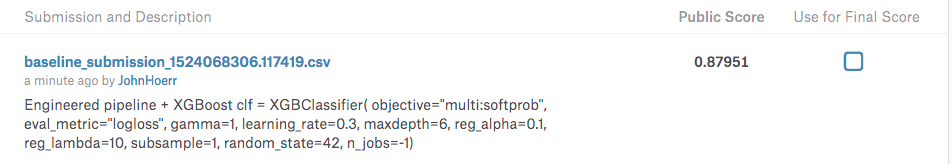

### Success/Failure Analysis

This week is notable in that my debugged engineered features + XGBoost yielded, with stastial significance, a stronger model than the baseline features + Logistic Regression (Softmax). The improvement was slight, however: I was only able to improve my Kaggle log loss by a mere ~0.01. This improved my Kaggle ranking by from ~930 to ~890, which is still pretty mediocre. 

At this point I think I can say with some confidence that my efforts will fail the stated objective of  providing meaningful predictions of shelter animal outcomes. It's worth noting that the best competition scores have a log loss of ~0.7. In light of this, and after working with this data, it's clear to me that a (the?) key piece of information missing from the inputs is what brought the animal to the shelter in the first place. This information is often included in the outcomes ("Euthanized: sick") but without having it as an input it's difficult to make any meaningful inferences about the animal's outcome.

If time permits in the next week I might try to do more feature engineering and my experiment with combining classifiers ala the 'kitchen sink' approach.' However, I do not anticipate that these efforts will meaningfully improve my accuracy.